# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [14]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

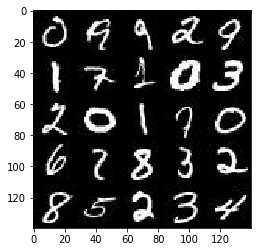

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

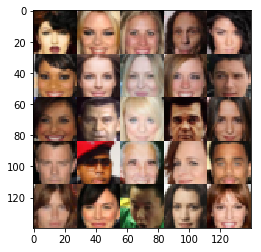

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    real_input = tf.placeholder(tf.float32,
                                (None, image_width, image_height, image_channels),
                                name='real_input')

    z_input = tf.placeholder(tf.float32,
                             (None, z_dim),
                             name='z_input')
    
    learning_rate = tf.placeholder(tf.float32, [], name='learning_rate')
    
    return (real_input, z_input, learning_rate)

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the generator, tensor logits of the generator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function

    alpha = .2  #.1  #.2

    with tf.variable_scope('discriminator', reuse=reuse):
        
        # Input layer is 28x28x3
        # Convolution
        x0 = tf.layers.conv2d(images, 32, 5, strides=2, padding='same')
        x0 = tf.maximum(alpha * x0, x0)  # LeakyReLu
        # 14x14x32 now
        
        # Convolution
        x1 = tf.layers.conv2d(x0, 64, 5, strides=2, padding='same')
        x1 = tf.layers.batch_normalization(x1, training=True)
        x1 = tf.maximum(alpha * x1, x1)
        # 7x7x64 now
        
        # Convolution
        x2 = tf.layers.conv2d(x1, 128, 5, strides=1, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=True)
        x2 = tf.maximum(alpha * x2, x2)
        # 7x7x128 now
        
        # Flatten
        flat = tf.reshape(x2, (-1, 7*7*128))
        logits = tf.layers.dense(flat, 1)
        output = tf.sigmoid(logits)

        return (output, logits)


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    
    alpha = .2  #.1  #.2
    
    with tf.variable_scope('generator', reuse=not is_train):

        # Fully Conn
        dense = tf.layers.dense(z, 7*7*64)
        
        # Reshape
        reshape = tf.reshape(dense, (-1, 7, 7, 64))
        # 7x7x64 now
        
        # Convolution
        x0 = tf.layers.conv2d_transpose(reshape, 32, 5, strides=2, padding='same')
        x0 = tf.layers.batch_normalization(x0, training=is_train)
        x0 = tf.maximum(alpha * x0, x0)
        # 14x14x32
        
        # Convolution
        x1 = tf.layers.conv2d_transpose(x0, 16, 5, strides=2, padding='same')
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        # 28x28x16
        
        # Convolution (logits)
        x2 = tf.layers.conv2d_transpose(x1, out_channel_dim, 5, strides=1, padding='same')
        # 28x28x3
        
        output = tf.tanh(x2)
        
        return output


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
    d_loss_real = tf.reduce_mean(
                    tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real,
                                                            labels=tf.ones_like(d_logits_real)))
    d_loss_fake = tf.reduce_mean(
                    tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake,
                                                            labels=tf.zeros_like(d_logits_real)))
    d_loss = d_loss_real + d_loss_fake
    
    g_loss = tf.reduce_mean(
                    tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake,
                                                            labels=tf.ones_like(d_logits_fake)))
    return (d_loss, g_loss)


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    
    t_vars = tf.trainable_variables()
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    
    g_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
    d_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
    
    return (d_opt, g_opt)


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    
    _, img_w, img_h, img_d = data_shape
    real_input, z_input, lr = model_inputs(img_w, img_h, img_d, z_dim)
    d_loss, g_loss = model_loss(real_input, z_input, img_d)
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    tile_size = 16  #images per tile
    iteration = 0
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                iteration += 1
                
                # TODO: Train Model
                z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                batch_images *= 2  # to expand the images range to -1. to +1. 
                _ = sess.run(d_opt, feed_dict={real_input: batch_images, z_input: z, lr:learning_rate})
                _ = sess.run(g_opt, feed_dict={z_input: z, lr:learning_rate})
                
                if iteration % 25 == 0:
                    dis_train_loss = d_loss.eval({z_input: z, real_input: batch_images})
                    gen_train_loss = g_loss.eval({z_input: z})
                    print("Epoch {}/{}...".format(epoch_i+1, epochs),
                          "Discriminator Loss: {:.4f}...".format(dis_train_loss),
                          "Generator Loss: {:.4f}".format(gen_train_loss))
                
                if iteration % 100 == 0:
                    show_generator_output(sess, tile_size, z_input, img_d, data_image_mode)
        # to show the final output             
        show_generator_output(sess, tile_size, z_input, img_d, data_image_mode)
                
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 3.0638... Generator Loss: 0.0847
Epoch 1/2... Discriminator Loss: 1.3620... Generator Loss: 3.3612
Epoch 1/2... Discriminator Loss: 1.3724... Generator Loss: 2.4162
Epoch 1/2... Discriminator Loss: 1.1406... Generator Loss: 0.5985


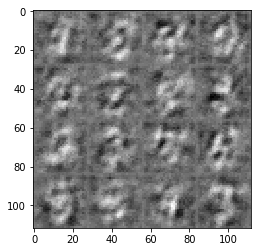

Epoch 1/2... Discriminator Loss: 1.0689... Generator Loss: 0.5802
Epoch 1/2... Discriminator Loss: 1.0623... Generator Loss: 0.6533
Epoch 1/2... Discriminator Loss: 0.8043... Generator Loss: 0.9474
Epoch 1/2... Discriminator Loss: 0.7256... Generator Loss: 1.0850


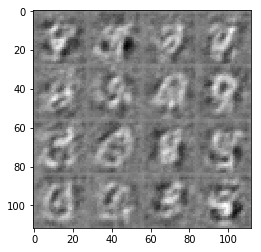

Epoch 1/2... Discriminator Loss: 0.9283... Generator Loss: 2.9133
Epoch 1/2... Discriminator Loss: 0.8190... Generator Loss: 0.8058
Epoch 1/2... Discriminator Loss: 1.1943... Generator Loss: 3.3296
Epoch 1/2... Discriminator Loss: 0.7028... Generator Loss: 1.3549


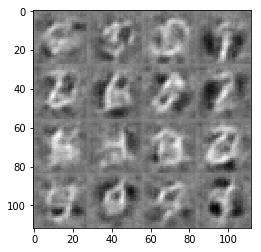

Epoch 1/2... Discriminator Loss: 0.9895... Generator Loss: 0.7730
Epoch 1/2... Discriminator Loss: 0.5461... Generator Loss: 1.4561
Epoch 1/2... Discriminator Loss: 0.7822... Generator Loss: 1.0783
Epoch 1/2... Discriminator Loss: 1.0345... Generator Loss: 0.6087


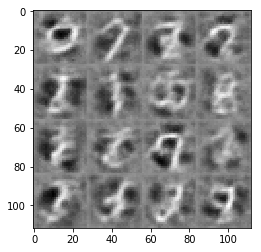

Epoch 1/2... Discriminator Loss: 0.9678... Generator Loss: 0.6879
Epoch 1/2... Discriminator Loss: 0.9723... Generator Loss: 1.2651
Epoch 1/2... Discriminator Loss: 0.7848... Generator Loss: 1.1887
Epoch 1/2... Discriminator Loss: 1.3816... Generator Loss: 0.4365


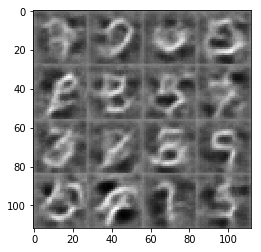

Epoch 1/2... Discriminator Loss: 0.7659... Generator Loss: 0.8582
Epoch 1/2... Discriminator Loss: 0.8468... Generator Loss: 0.8933
Epoch 1/2... Discriminator Loss: 0.7325... Generator Loss: 1.0128
Epoch 1/2... Discriminator Loss: 3.2350... Generator Loss: 4.3715


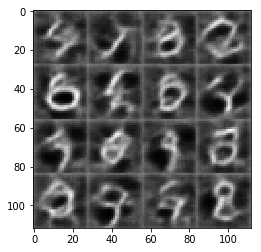

Epoch 1/2... Discriminator Loss: 0.9577... Generator Loss: 0.6802
Epoch 1/2... Discriminator Loss: 0.9528... Generator Loss: 0.6590
Epoch 1/2... Discriminator Loss: 0.6744... Generator Loss: 0.9936
Epoch 1/2... Discriminator Loss: 0.6789... Generator Loss: 1.4396


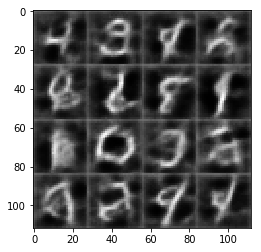

Epoch 1/2... Discriminator Loss: 0.6508... Generator Loss: 1.0329
Epoch 1/2... Discriminator Loss: 0.5628... Generator Loss: 1.5479
Epoch 1/2... Discriminator Loss: 0.6158... Generator Loss: 1.0814
Epoch 1/2... Discriminator Loss: 0.5978... Generator Loss: 1.1026


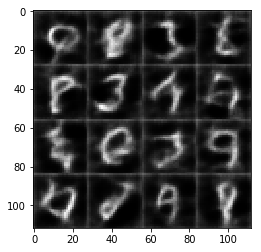

Epoch 1/2... Discriminator Loss: 0.6237... Generator Loss: 1.5502
Epoch 1/2... Discriminator Loss: 0.5543... Generator Loss: 1.5845
Epoch 1/2... Discriminator Loss: 0.4748... Generator Loss: 1.3677
Epoch 1/2... Discriminator Loss: 1.7399... Generator Loss: 2.8843


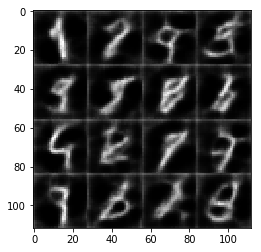

Epoch 1/2... Discriminator Loss: 0.4697... Generator Loss: 2.0337
Epoch 2/2... Discriminator Loss: 0.9111... Generator Loss: 0.7933
Epoch 2/2... Discriminator Loss: 0.6460... Generator Loss: 1.2039
Epoch 2/2... Discriminator Loss: 0.7122... Generator Loss: 0.9125


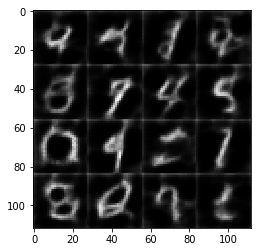

Epoch 2/2... Discriminator Loss: 0.7074... Generator Loss: 1.8509
Epoch 2/2... Discriminator Loss: 0.8561... Generator Loss: 0.9179
Epoch 2/2... Discriminator Loss: 0.4772... Generator Loss: 1.5502
Epoch 2/2... Discriminator Loss: 0.5188... Generator Loss: 1.6177


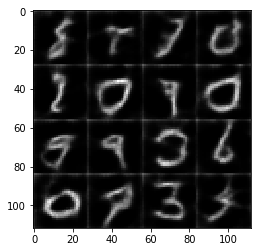

Epoch 2/2... Discriminator Loss: 1.2094... Generator Loss: 0.6092
Epoch 2/2... Discriminator Loss: 0.5894... Generator Loss: 1.2011
Epoch 2/2... Discriminator Loss: 0.6717... Generator Loss: 1.7955
Epoch 2/2... Discriminator Loss: 0.8731... Generator Loss: 0.7224


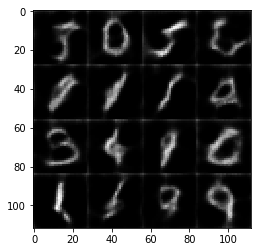

Epoch 2/2... Discriminator Loss: 3.3460... Generator Loss: 0.0731
Epoch 2/2... Discriminator Loss: 0.8422... Generator Loss: 0.8193
Epoch 2/2... Discriminator Loss: 0.6113... Generator Loss: 1.1683
Epoch 2/2... Discriminator Loss: 0.5316... Generator Loss: 1.2956


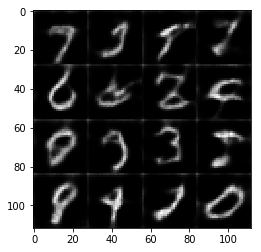

Epoch 2/2... Discriminator Loss: 0.6015... Generator Loss: 1.1339
Epoch 2/2... Discriminator Loss: 0.4914... Generator Loss: 2.4870
Epoch 2/2... Discriminator Loss: 0.5682... Generator Loss: 1.2472
Epoch 2/2... Discriminator Loss: 0.6270... Generator Loss: 1.0957


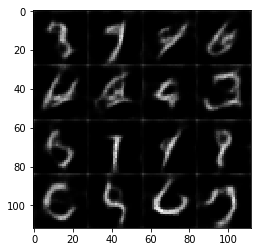

Epoch 2/2... Discriminator Loss: 0.6474... Generator Loss: 1.8175
Epoch 2/2... Discriminator Loss: 0.7305... Generator Loss: 0.9840
Epoch 2/2... Discriminator Loss: 0.6002... Generator Loss: 1.1199
Epoch 2/2... Discriminator Loss: 0.7315... Generator Loss: 1.0338


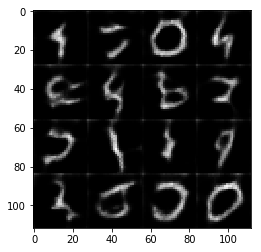

Epoch 2/2... Discriminator Loss: 0.3637... Generator Loss: 1.5976
Epoch 2/2... Discriminator Loss: 0.3730... Generator Loss: 2.3053
Epoch 2/2... Discriminator Loss: 0.6494... Generator Loss: 1.0911
Epoch 2/2... Discriminator Loss: 0.4194... Generator Loss: 1.9433


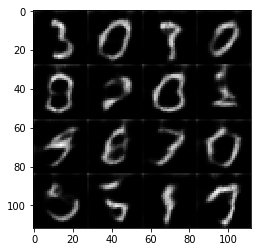

Epoch 2/2... Discriminator Loss: 3.2333... Generator Loss: 0.1099
Epoch 2/2... Discriminator Loss: 0.4434... Generator Loss: 1.8756
Epoch 2/2... Discriminator Loss: 0.3599... Generator Loss: 2.1597
Epoch 2/2... Discriminator Loss: 0.4824... Generator Loss: 1.3938


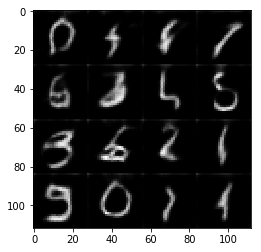

Epoch 2/2... Discriminator Loss: 4.9094... Generator Loss: 7.7658
Epoch 2/2... Discriminator Loss: 1.0768... Generator Loss: 0.7245
Epoch 2/2... Discriminator Loss: 0.4315... Generator Loss: 1.9681
Epoch 2/2... Discriminator Loss: 0.6914... Generator Loss: 0.9912


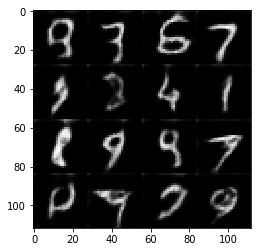

Epoch 2/2... Discriminator Loss: 0.3351... Generator Loss: 1.7383
Epoch 2/2... Discriminator Loss: 2.4916... Generator Loss: 6.5571


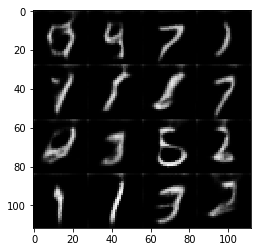

In [12]:
batch_size = 64  #64  #20  #5 
z_dim = 100  #255
learning_rate = .0006  # .001  #0.0001
beta1 = .5  #.6 #.7 #.8 #.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 5.6996... Generator Loss: 0.0099
Epoch 1/1... Discriminator Loss: 0.4934... Generator Loss: 1.5822
Epoch 1/1... Discriminator Loss: 0.4907... Generator Loss: 2.0167
Epoch 1/1... Discriminator Loss: 0.3588... Generator Loss: 2.2709


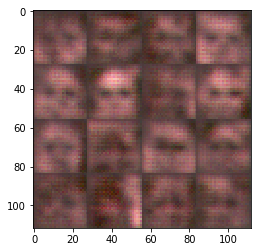

Epoch 1/1... Discriminator Loss: 0.1016... Generator Loss: 3.5288
Epoch 1/1... Discriminator Loss: 0.4730... Generator Loss: 4.4759
Epoch 1/1... Discriminator Loss: 1.7352... Generator Loss: 0.3486
Epoch 1/1... Discriminator Loss: 0.4604... Generator Loss: 4.8367


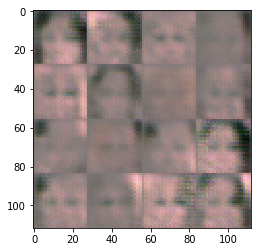

Epoch 1/1... Discriminator Loss: 0.1697... Generator Loss: 3.5436
Epoch 1/1... Discriminator Loss: 0.8403... Generator Loss: 1.1200
Epoch 1/1... Discriminator Loss: 0.4302... Generator Loss: 2.3734
Epoch 1/1... Discriminator Loss: 0.6050... Generator Loss: 1.6715


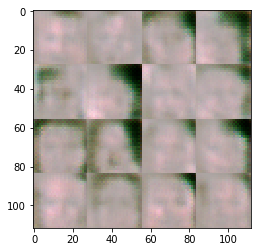

Epoch 1/1... Discriminator Loss: 0.9505... Generator Loss: 2.8495
Epoch 1/1... Discriminator Loss: 0.5767... Generator Loss: 1.7274
Epoch 1/1... Discriminator Loss: 0.9850... Generator Loss: 2.6684
Epoch 1/1... Discriminator Loss: 0.2620... Generator Loss: 3.4353


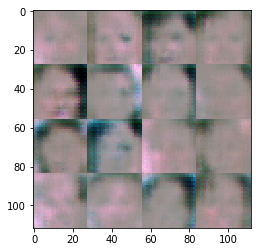

Epoch 1/1... Discriminator Loss: 0.8757... Generator Loss: 0.9246
Epoch 1/1... Discriminator Loss: 1.1957... Generator Loss: 0.6920
Epoch 1/1... Discriminator Loss: 0.9755... Generator Loss: 2.0872
Epoch 1/1... Discriminator Loss: 1.0605... Generator Loss: 0.9821


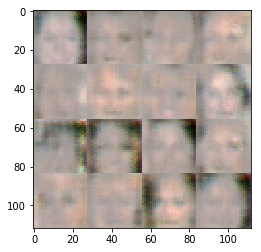

Epoch 1/1... Discriminator Loss: 0.9836... Generator Loss: 0.9070
Epoch 1/1... Discriminator Loss: 0.8840... Generator Loss: 1.5669
Epoch 1/1... Discriminator Loss: 1.1983... Generator Loss: 0.7767
Epoch 1/1... Discriminator Loss: 0.8574... Generator Loss: 1.1124


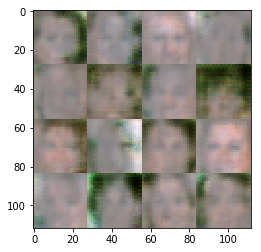

Epoch 1/1... Discriminator Loss: 1.8762... Generator Loss: 0.6179
Epoch 1/1... Discriminator Loss: 0.7529... Generator Loss: 1.9472
Epoch 1/1... Discriminator Loss: 1.7748... Generator Loss: 0.3355
Epoch 1/1... Discriminator Loss: 0.9272... Generator Loss: 1.5191


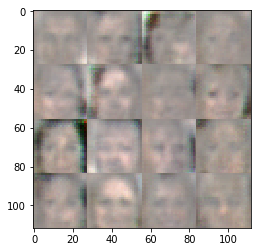

Epoch 1/1... Discriminator Loss: 1.6658... Generator Loss: 1.0298
Epoch 1/1... Discriminator Loss: 0.9715... Generator Loss: 0.9765
Epoch 1/1... Discriminator Loss: 0.9600... Generator Loss: 1.0770
Epoch 1/1... Discriminator Loss: 1.2508... Generator Loss: 0.9074


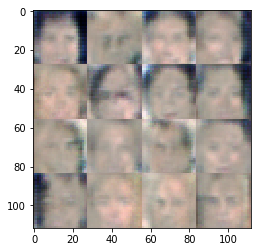

Epoch 1/1... Discriminator Loss: 0.8638... Generator Loss: 1.1202
Epoch 1/1... Discriminator Loss: 0.8367... Generator Loss: 0.9342
Epoch 1/1... Discriminator Loss: 1.1891... Generator Loss: 1.5000
Epoch 1/1... Discriminator Loss: 1.3430... Generator Loss: 0.9132


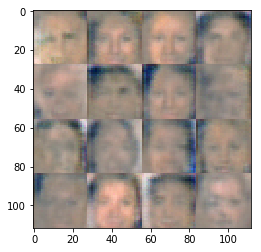

Epoch 1/1... Discriminator Loss: 1.1671... Generator Loss: 0.9368
Epoch 1/1... Discriminator Loss: 1.3297... Generator Loss: 1.3807
Epoch 1/1... Discriminator Loss: 0.9900... Generator Loss: 1.5383
Epoch 1/1... Discriminator Loss: 0.8183... Generator Loss: 1.4665


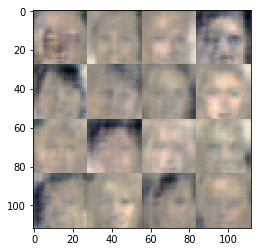

Epoch 1/1... Discriminator Loss: 1.5977... Generator Loss: 0.9166
Epoch 1/1... Discriminator Loss: 0.9043... Generator Loss: 1.2324
Epoch 1/1... Discriminator Loss: 1.1750... Generator Loss: 1.4425
Epoch 1/1... Discriminator Loss: 1.0749... Generator Loss: 1.1525


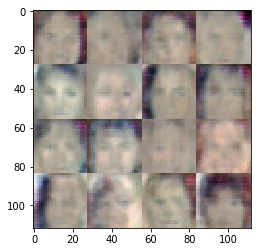

Epoch 1/1... Discriminator Loss: 1.0918... Generator Loss: 0.8530
Epoch 1/1... Discriminator Loss: 1.0596... Generator Loss: 1.1098
Epoch 1/1... Discriminator Loss: 1.2184... Generator Loss: 1.3092
Epoch 1/1... Discriminator Loss: 1.1242... Generator Loss: 1.1467


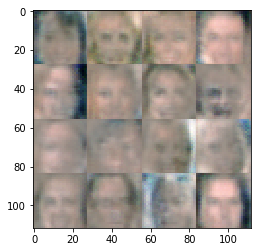

Epoch 1/1... Discriminator Loss: 1.1596... Generator Loss: 0.9767
Epoch 1/1... Discriminator Loss: 1.1337... Generator Loss: 1.8772
Epoch 1/1... Discriminator Loss: 1.4363... Generator Loss: 1.1484
Epoch 1/1... Discriminator Loss: 1.2293... Generator Loss: 1.3222


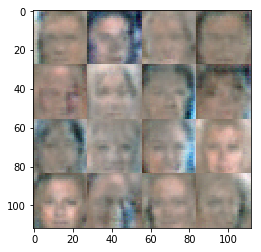

Epoch 1/1... Discriminator Loss: 1.1594... Generator Loss: 0.7972
Epoch 1/1... Discriminator Loss: 1.0301... Generator Loss: 0.9032
Epoch 1/1... Discriminator Loss: 1.4494... Generator Loss: 1.1492
Epoch 1/1... Discriminator Loss: 1.0051... Generator Loss: 1.5202


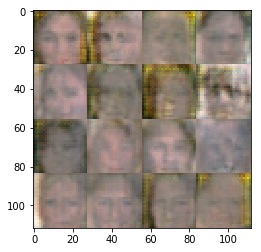

Epoch 1/1... Discriminator Loss: 0.7931... Generator Loss: 1.4883
Epoch 1/1... Discriminator Loss: 1.6931... Generator Loss: 0.3732
Epoch 1/1... Discriminator Loss: 1.2815... Generator Loss: 1.3666
Epoch 1/1... Discriminator Loss: 1.0583... Generator Loss: 1.1898


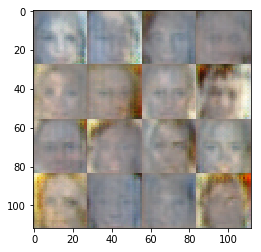

Epoch 1/1... Discriminator Loss: 1.2552... Generator Loss: 0.7847
Epoch 1/1... Discriminator Loss: 1.0954... Generator Loss: 1.2271
Epoch 1/1... Discriminator Loss: 1.2028... Generator Loss: 1.3236
Epoch 1/1... Discriminator Loss: 1.2753... Generator Loss: 1.1457


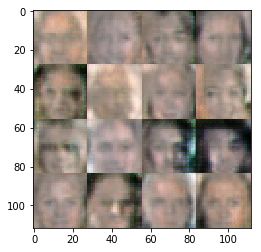

Epoch 1/1... Discriminator Loss: 1.1733... Generator Loss: 1.1968
Epoch 1/1... Discriminator Loss: 1.3021... Generator Loss: 0.6392
Epoch 1/1... Discriminator Loss: 1.0426... Generator Loss: 0.7118
Epoch 1/1... Discriminator Loss: 1.4709... Generator Loss: 1.6288


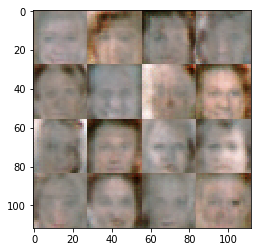

Epoch 1/1... Discriminator Loss: 1.1614... Generator Loss: 0.7507
Epoch 1/1... Discriminator Loss: 0.9875... Generator Loss: 0.9979
Epoch 1/1... Discriminator Loss: 1.0432... Generator Loss: 1.2064
Epoch 1/1... Discriminator Loss: 0.8849... Generator Loss: 0.9913


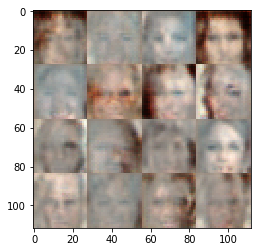

Epoch 1/1... Discriminator Loss: 0.9328... Generator Loss: 1.1116
Epoch 1/1... Discriminator Loss: 0.6627... Generator Loss: 1.2057
Epoch 1/1... Discriminator Loss: 0.8836... Generator Loss: 1.7789
Epoch 1/1... Discriminator Loss: 0.9853... Generator Loss: 1.2497


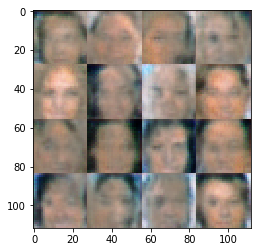

Epoch 1/1... Discriminator Loss: 0.9399... Generator Loss: 1.4829
Epoch 1/1... Discriminator Loss: 0.7266... Generator Loss: 1.4849
Epoch 1/1... Discriminator Loss: 0.8805... Generator Loss: 1.7094
Epoch 1/1... Discriminator Loss: 1.3633... Generator Loss: 1.0885


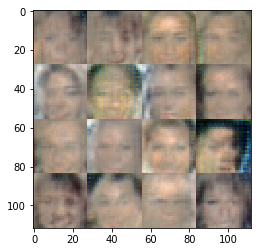

Epoch 1/1... Discriminator Loss: 1.4937... Generator Loss: 0.7253
Epoch 1/1... Discriminator Loss: 1.6680... Generator Loss: 0.5316
Epoch 1/1... Discriminator Loss: 1.3528... Generator Loss: 0.7992
Epoch 1/1... Discriminator Loss: 1.2881... Generator Loss: 0.7406


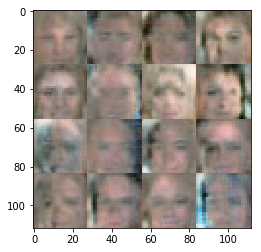

Epoch 1/1... Discriminator Loss: 0.9944... Generator Loss: 1.1040
Epoch 1/1... Discriminator Loss: 1.0792... Generator Loss: 1.1902
Epoch 1/1... Discriminator Loss: 0.9005... Generator Loss: 1.2159
Epoch 1/1... Discriminator Loss: 1.0604... Generator Loss: 0.9299


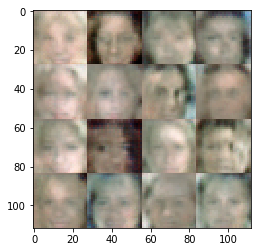

Epoch 1/1... Discriminator Loss: 1.0924... Generator Loss: 1.0023
Epoch 1/1... Discriminator Loss: 1.2542... Generator Loss: 1.1895
Epoch 1/1... Discriminator Loss: 1.2585... Generator Loss: 0.9947
Epoch 1/1... Discriminator Loss: 1.4737... Generator Loss: 0.8045


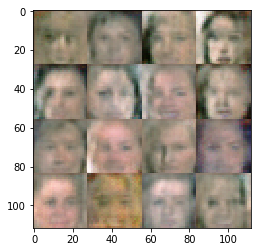

Epoch 1/1... Discriminator Loss: 1.0550... Generator Loss: 1.2148
Epoch 1/1... Discriminator Loss: 1.2802... Generator Loss: 1.2234
Epoch 1/1... Discriminator Loss: 1.1755... Generator Loss: 1.3510
Epoch 1/1... Discriminator Loss: 0.9772... Generator Loss: 0.8989


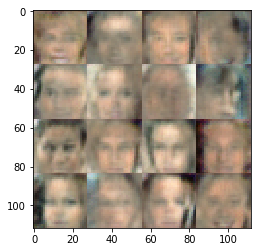

Epoch 1/1... Discriminator Loss: 0.9228... Generator Loss: 1.0090
Epoch 1/1... Discriminator Loss: 1.2113... Generator Loss: 0.9062
Epoch 1/1... Discriminator Loss: 1.0902... Generator Loss: 0.9641
Epoch 1/1... Discriminator Loss: 1.4440... Generator Loss: 1.4219


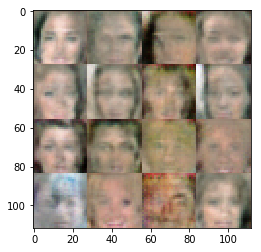

Epoch 1/1... Discriminator Loss: 1.5585... Generator Loss: 0.4899
Epoch 1/1... Discriminator Loss: 0.9961... Generator Loss: 0.9475
Epoch 1/1... Discriminator Loss: 1.1126... Generator Loss: 1.2716
Epoch 1/1... Discriminator Loss: 1.0257... Generator Loss: 1.0180


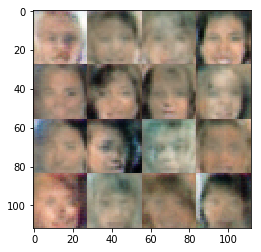

Epoch 1/1... Discriminator Loss: 1.2898... Generator Loss: 0.9210
Epoch 1/1... Discriminator Loss: 1.2717... Generator Loss: 0.8144
Epoch 1/1... Discriminator Loss: 0.9713... Generator Loss: 1.2013
Epoch 1/1... Discriminator Loss: 1.1817... Generator Loss: 1.3908


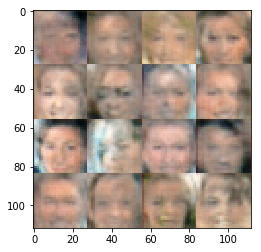

Epoch 1/1... Discriminator Loss: 0.9554... Generator Loss: 1.0956
Epoch 1/1... Discriminator Loss: 1.1756... Generator Loss: 1.3024
Epoch 1/1... Discriminator Loss: 1.3200... Generator Loss: 0.6047
Epoch 1/1... Discriminator Loss: 0.9081... Generator Loss: 1.3178


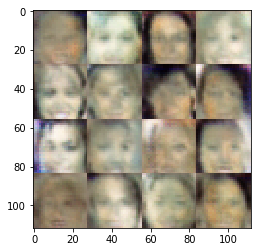

Epoch 1/1... Discriminator Loss: 1.3691... Generator Loss: 0.7087
Epoch 1/1... Discriminator Loss: 0.9196... Generator Loss: 1.0875
Epoch 1/1... Discriminator Loss: 1.3399... Generator Loss: 0.9323
Epoch 1/1... Discriminator Loss: 0.9091... Generator Loss: 1.1933


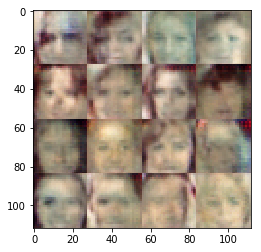

Epoch 1/1... Discriminator Loss: 1.1782... Generator Loss: 1.0931
Epoch 1/1... Discriminator Loss: 1.3125... Generator Loss: 0.8607
Epoch 1/1... Discriminator Loss: 1.1312... Generator Loss: 1.1640
Epoch 1/1... Discriminator Loss: 0.8853... Generator Loss: 1.1608


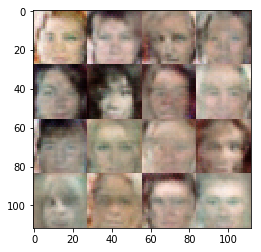

Epoch 1/1... Discriminator Loss: 1.1010... Generator Loss: 1.2052
Epoch 1/1... Discriminator Loss: 1.3185... Generator Loss: 0.7202
Epoch 1/1... Discriminator Loss: 1.2773... Generator Loss: 0.6665
Epoch 1/1... Discriminator Loss: 0.8782... Generator Loss: 1.2970


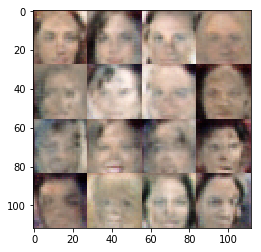

Epoch 1/1... Discriminator Loss: 1.0371... Generator Loss: 1.3418
Epoch 1/1... Discriminator Loss: 1.2547... Generator Loss: 1.0247


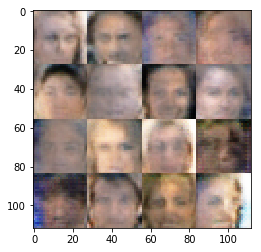

In [13]:
batch_size = 64  #128  #64  #16  #64  #20  #5 
z_dim = 100  #128 # 200 #255
learning_rate = .0008  #.001  #.0001
beta1 = .7  #.45 #.6 #.8 #.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.